## 📊 Dataset Statistics

| Dataset | Total | Normal | Abnormal |
|---------|-------|--------|----------|
| **NIH** | 112,120 | 60,361 (53.8%) | 51,759 (46.2%) |
| **Pediatric** | 5,856 | 1,583 (27.0%) | 4,273 (73.0%) |
| **CheXpert** | 29,031 | 1,123 (3.9%) | 27,908 (96.1%) |

In [ ]:
# Notebook display tweaks: compact code, scrollable outputs, clearer tables
from IPython.display import HTML
HTML("""
<style>
:root {
  --code-font-size: 12px;
  --input-max-height: 200px;
  --output-font-size: 14px;
  --output-max-height: 400px;
  --output-line-height: 1.35;
}
div.cell.code_cell .input_area {
  max-height: var(--input-max-height);
  overflow: auto;
  font-size: var(--code-font-size);
}
div.cell.code_cell .CodeMirror-lines {
  font-size: var(--code-font-size);
}
div.output_wrapper, div.output {
  font-size: var(--output-font-size);
  line-height: var(--output-line-height);
}
div.output_subarea {
  max-height: var(--output-max-height);
  overflow: auto;
}
</style>
""")

import pandas as pd
pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", 20)
pd.set_option("display.width", 120)
pd.set_option("display.max_colwidth", 120)
pd.set_option("display.float_format", "{:.4f}".format)


---
# 🔧 Setup & Environment

In [1]:
# Check current working directory
import os
from pathlib import Path

print(f"Current working directory: {os.getcwd()}")
print(f"Python version: {os.sys.version}")

Current working directory: c:\Moataz CAS\projectM3\CAS-AML-M3-Project-AE
Python version: 3.11.0 (main, Oct 24 2022, 18:26:48) [MSC v.1933 64 bit (AMD64)]


In [2]:
# Define project paths (auto-detect repo root; override if needed)
from pathlib import Path

# Set to your data root if different from the current working directory
OVERRIDE_PROJECT_ROOT = Path(r"F:\\CAS AML\\M3_project\\downloads")

PROJECT_ROOT = Path(OVERRIDE_PROJECT_ROOT) if OVERRIDE_PROJECT_ROOT else Path.cwd()

DATA_DIR = PROJECT_ROOT / "data" / "processed"
LABELS_DIR = PROJECT_ROOT / "data" / "labels"
SCRIPTS_DIR = PROJECT_ROOT / "scripts"
RESULTS_DIR = PROJECT_ROOT / "Results"
MODELS_DIR = PROJECT_ROOT / "models"

for directory in [DATA_DIR, LABELS_DIR, SCRIPTS_DIR, RESULTS_DIR, MODELS_DIR]:
    directory.mkdir(parents=True, exist_ok=True)
    print(f"? {directory.name}: {directory}")

import sys
if str(SCRIPTS_DIR) not in sys.path:
    sys.path.insert(0, str(SCRIPTS_DIR))

print(f"\n? Project root: {PROJECT_ROOT}")
print(f"? Data dir: {DATA_DIR}")


? processed: F:\CAS AML\M3_project\downloads\data\processed
? labels: F:\CAS AML\M3_project\downloads\data\labels
? scripts: F:\CAS AML\M3_project\downloads\scripts
? Results: F:\CAS AML\M3_project\downloads\Results
? models: F:\CAS AML\M3_project\downloads\models

? Project root: F:\CAS AML\M3_project\downloads
? Data dir: F:\CAS AML\M3_project\downloads\data\processed


### Import Libraries (Keras 3.x)

In [3]:
import os
os.environ['KERAS_BACKEND'] = 'torch'  # Options: 'torch', 'tensorflow', 'jax'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import (
    roc_auc_score, accuracy_score, balanced_accuracy_score,
    classification_report, confusion_matrix, roc_curve
)
import h5py
import keras
from keras import layers, models, callbacks, optimizers
import json
from pathlib import Path
import gc

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print(f"✅ Keras version: {keras.__version__}")
print(f"✅ Keras backend: {keras.backend.backend()}")
print(f"✅ NumPy version: {np.__version__}")
print(f"✅ Pandas version: {pd.__version__}")

✅ Keras version: 3.12.0
✅ Keras backend: torch
✅ NumPy version: 1.26.4
✅ Pandas version: 2.3.3


In [4]:
# Check GPU availability
backend = keras.backend.backend()

if backend == 'torch':
    import torch
    print(f"PyTorch version: {torch.__version__}")
    print(f"CUDA available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"CUDA version: {torch.version.cuda}")
        print(f"GPU: {torch.cuda.get_device_name(0)}")
        print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
elif backend == 'tensorflow':
    import tensorflow as tf
    print(f"TensorFlow version: {tf.__version__}")
    print(f"GPU devices: {tf.config.list_physical_devices('GPU')}")
elif backend == 'jax':
    import jax
    print(f"JAX version: {jax.__version__}")
    print(f"JAX devices: {jax.devices()}")

PyTorch version: 2.5.1+cu121
CUDA available: True
CUDA version: 12.1
GPU: NVIDIA GeForce RTX 4060
GPU memory: 8.0 GB


---
# 📁 Phase 1: Baseline Statistical Analysis

## Phase 1a: All Data Comparison

**Goal:** Quantify baseline distribution shift using all images (mixed pathologies)

In [5]:
# Load test images from all datasets
print("="*80)
print("PHASE 1a: LOADING TEST DATA (ALL IMAGES)")
print("="*80)

datasets = {}

for dataset_name in ['nih', 'pediatric', 'chexpert']:
    h5_path = DATA_DIR / dataset_name / 'test.h5'
    
    if not h5_path.exists():
        print(f"⚠️  {dataset_name}: File not found - {h5_path}")
        continue
    
    print(f"\n📂 Loading {dataset_name}...")
    
    with h5py.File(h5_path, 'r') as f:
        images = f['images'][:]
        labels = f['labels'][:]
        
    datasets[dataset_name] = {
        'images': images,
        'labels': labels,
        'n_samples': len(images)
    }
    
    print(f"   Shape: {images.shape}")
    print(f"   Samples: {len(images):,}")
    print(f"   Memory: {images.nbytes / 1024**2:.1f} MB")

print(f"\n✅ Loaded {len(datasets)} datasets")

PHASE 1a: LOADING TEST DATA (ALL IMAGES)

📂 Loading nih...
   Shape: (16655, 224, 224, 1)
   Samples: 16,655
   Memory: 3187.9 MB

📂 Loading pediatric...
   Shape: (879, 224, 224, 1)
   Samples: 879
   Memory: 168.2 MB

📂 Loading chexpert...
   Shape: (29031, 224, 224, 1)
   Samples: 29,031
   Memory: 5556.7 MB

✅ Loaded 3 datasets


In [6]:
# Compute pixel statistics
print("\n" + "="*80)
print("COMPUTING PIXEL STATISTICS")
print("="*80)

stats_1a = []

for name, data in datasets.items():
    images = data['images']
    
    stat = {
        'Dataset': name.upper(),
        'Mean': images.mean(),
        'Std': images.std(),
        'Min': images.min(),
        'Max': images.max(),
        'Median': np.median(images),
        'Q25': np.percentile(images, 25),
        'Q75': np.percentile(images, 75)
    }
    stats_1a.append(stat)
    
    print(f"\n{name.upper()}:")
    print(f"  Mean:   {stat['Mean']:.4f}")
    print(f"  Std:    {stat['Std']:.4f}")
    print(f"  Range:  [{stat['Min']:.4f}, {stat['Max']:.4f}]")
    print(f"  Median: {stat['Median']:.4f}")

df_stats_1a = pd.DataFrame(stats_1a)
print("\n" + df_stats_1a.to_string(index=False))


COMPUTING PIXEL STATISTICS

NIH:
  Mean:   -0.0042
  Std:    0.4952
  Range:  [-1.0000, 1.0000]
  Median: 0.0431

PEDIATRIC:
  Mean:   -0.0416
  Std:    0.4738
  Range:  [-1.0000, 1.0000]
  Median: 0.0431

CHEXPERT:
  Mean:   0.0127
  Std:    0.5744
  Range:  [-1.0000, 1.0000]
  Median: 0.0196

  Dataset      Mean      Std  Min  Max   Median       Q25      Q75
      NIH -0.004235 0.495229 -1.0  1.0 0.043137 -0.349020 0.388235
PEDIATRIC -0.041632 0.473798 -1.0  1.0 0.043137 -0.372549 0.349020
 CHEXPERT  0.012683 0.574401 -1.0  1.0 0.019608 -0.482353 0.505882


In [7]:
# Compute JS Divergence
from scipy.spatial.distance import jensenshannon

def compute_js_divergence(images1, images2, bins=100):
    """Compute Jensen-Shannon divergence between two image distributions"""
    hist1, _ = np.histogram(images1.flatten(), bins=bins, range=(0, 1), density=True)
    hist2, _ = np.histogram(images2.flatten(), bins=bins, range=(0, 1), density=True)
    
    # Normalize to probability distributions
    hist1 = hist1 / hist1.sum()
    hist2 = hist2 / hist2.sum()
    
    return jensenshannon(hist1, hist2)

print("\n" + "="*80)
print("COMPUTING JENSEN-SHANNON DIVERGENCE")
print("="*80)

js_results_1a = []
dataset_names = list(datasets.keys())

for i, name1 in enumerate(dataset_names):
    for name2 in dataset_names[i+1:]:
        js_div = compute_js_divergence(
            datasets[name1]['images'],
            datasets[name2]['images']
        )
        
        js_results_1a.append({
            'Dataset1': name1.upper(),
            'Dataset2': name2.upper(),
            'JS_Divergence': js_div
        })
        
        print(f"  {name1.upper():10s} vs {name2.upper():10s}: {js_div:.4f}")

df_js_1a = pd.DataFrame(js_results_1a)

# Save results
phase1a_dir = RESULTS_DIR / 'phase1a'
phase1a_dir.mkdir(parents=True, exist_ok=True)

df_stats_1a.to_csv(phase1a_dir / 'phase1a_statistics.csv', index=False)
df_js_1a.to_csv(phase1a_dir / 'phase1a_js_divergence.csv', index=False)

print(f"\n✅ Results saved to {phase1a_dir}")


COMPUTING JENSEN-SHANNON DIVERGENCE
  NIH        vs PEDIATRIC : 0.1560
  NIH        vs CHEXPERT  : 0.2140
  PEDIATRIC  vs CHEXPERT  : 0.3089

✅ Results saved to F:\CAS AML\M3_project\downloads\Results\phase1a


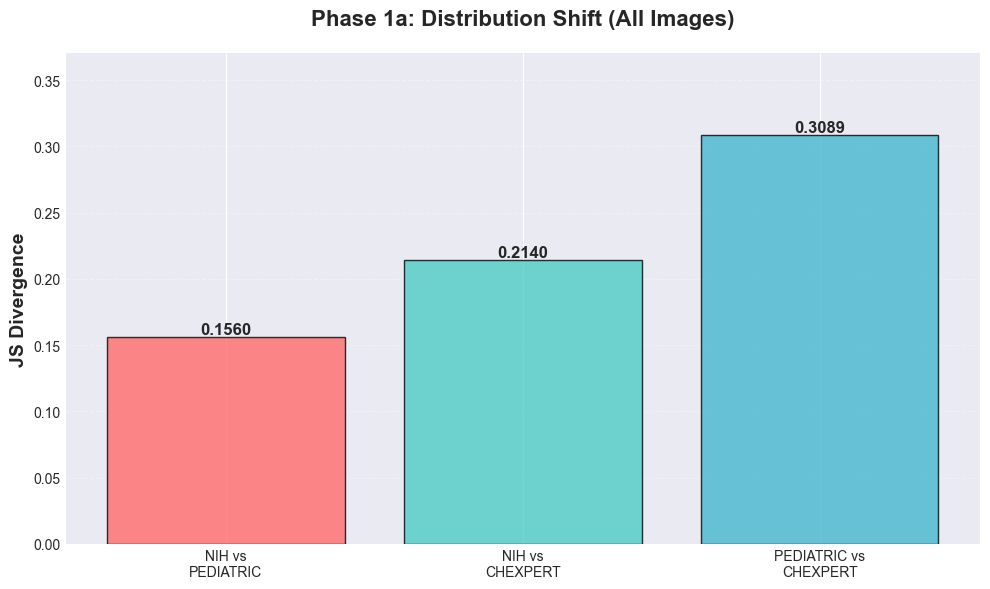

✅ Visualization saved


In [8]:
# Visualize JS Divergence
fig, ax = plt.subplots(figsize=(10, 6))

comparisons = [f"{row['Dataset1']} vs\n{row['Dataset2']}" for _, row in df_js_1a.iterrows()]
values = df_js_1a['JS_Divergence'].values

bars = ax.bar(comparisons, values, color=['#FF6B6B', '#4ECDC4', '#45B7D1'], alpha=0.8, edgecolor='black')

# Add value labels on bars
for bar, val in zip(bars, values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.4f}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('JS Divergence', fontsize=14, fontweight='bold')
ax.set_title('Phase 1a: Distribution Shift (All Images)', fontsize=16, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_ylim(0, max(values) * 1.2)

plt.tight_layout()
plt.savefig(phase1a_dir / 'phase1a_js_divergence.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualization saved")

## Phase 1b: Normals-Only Comparison

**Goal:** Isolate institutional/demographic shift by controlling for pathology

In [9]:
# Load normal images only
print("="*80)
print("PHASE 1b: LOADING NORMAL IMAGES ONLY")
print("="*80)

datasets_normal = {}

for dataset_name in ['nih', 'pediatric', 'chexpert']:
    h5_path = DATA_DIR / dataset_name / 'test_normals.h5'
    
    if not h5_path.exists():
        print(f"⚠️  {dataset_name}: File not found - {h5_path}")
        continue
    
    print(f"\n📂 Loading {dataset_name} normals...")
    
    with h5py.File(h5_path, 'r') as f:
        images = f['images'][:]
        labels = f['labels'][:]
        
    datasets_normal[dataset_name] = {
        'images': images,
        'labels': labels,
        'n_samples': len(images)
    }
    
    print(f"   Shape: {images.shape}")
    print(f"   Samples: {len(images):,}")

print(f"\n✅ Loaded {len(datasets_normal)} datasets (normals only)")

PHASE 1b: LOADING NORMAL IMAGES ONLY

📂 Loading nih normals...
   Shape: (8902, 224, 224, 1)
   Samples: 8,902

📂 Loading pediatric normals...
   Shape: (238, 224, 224, 1)
   Samples: 238

📂 Loading chexpert normals...
   Shape: (1123, 224, 224, 1)
   Samples: 1,123

✅ Loaded 3 datasets (normals only)


In [10]:
# Compute statistics and JS divergence for normals
print("\n" + "="*80)
print("COMPUTING STATISTICS FOR NORMALS")
print("="*80)

stats_1b = []
js_results_1b = []

# Statistics
for name, data in datasets_normal.items():
    images = data['images']
    stat = {
        'Dataset': name.upper(),
        'Mean': images.mean(),
        'Std': images.std(),
        'Min': images.min(),
        'Max': images.max(),
        'Median': np.median(images)
    }
    stats_1b.append(stat)

# JS Divergence
dataset_names = list(datasets_normal.keys())
for i, name1 in enumerate(dataset_names):
    for name2 in dataset_names[i+1:]:
        js_div = compute_js_divergence(
            datasets_normal[name1]['images'],
            datasets_normal[name2]['images']
        )
        
        js_results_1b.append({
            'Dataset1': name1.upper(),
            'Dataset2': name2.upper(),
            'JS_Divergence': js_div
        })
        
        print(f"  {name1.upper():10s} vs {name2.upper():10s}: {js_div:.4f}")

df_stats_1b = pd.DataFrame(stats_1b)
df_js_1b = pd.DataFrame(js_results_1b)

# Save results
phase1b_dir = RESULTS_DIR / 'phase1b'
phase1b_dir.mkdir(parents=True, exist_ok=True)

df_stats_1b.to_csv(phase1b_dir / 'phase1b_statistics.csv', index=False)
df_js_1b.to_csv(phase1b_dir / 'phase1b_js_divergence.csv', index=False)

print(f"\n✅ Results saved to {phase1b_dir}")


COMPUTING STATISTICS FOR NORMALS
  NIH        vs PEDIATRIC : 0.1031
  NIH        vs CHEXPERT  : 0.2101
  PEDIATRIC  vs CHEXPERT  : 0.2669

✅ Results saved to F:\CAS AML\M3_project\downloads\Results\phase1b


---
# 📁 Phase 2: Autoencoder Training

## Phase 2a: NIH_Full Autoencoder

**Data:** All NIH images (normals + abnormals)  
**Architecture:** Convolutional autoencoder with 256-dim latent space

In [11]:
# Build autoencoder architecture
def build_autoencoder(input_shape=(224, 224, 1), latent_dim=256):
    """
    Build convolutional autoencoder
    
    Args:
        input_shape: Input image shape
        latent_dim: Latent space dimension
        
    Returns:
        encoder, decoder, autoencoder models
    """
    
    # ENCODER
    encoder_input = layers.Input(shape=input_shape, name='encoder_input')
    
    x = layers.Conv2D(32, 3, activation='relu', padding='same', name='enc_conv1')(encoder_input)
    x = layers.MaxPooling2D(2, padding='same', name='enc_pool1')(x)
    
    x = layers.Conv2D(64, 3, activation='relu', padding='same', name='enc_conv2')(x)
    x = layers.MaxPooling2D(2, padding='same', name='enc_pool2')(x)
    
    x = layers.Conv2D(128, 3, activation='relu', padding='same', name='enc_conv3')(x)
    x = layers.MaxPooling2D(2, padding='same', name='enc_pool3')(x)
    
    x = layers.Conv2D(256, 3, activation='relu', padding='same', name='enc_conv4')(x)
    x = layers.MaxPooling2D(2, padding='same', name='enc_pool4')(x)
    
    x = layers.Flatten(name='enc_flatten')(x)
    encoder_output = layers.Dense(latent_dim, activation='relu', name='latent')(x)
    
    encoder = models.Model(encoder_input, encoder_output, name='encoder')
    
    # DECODER
    decoder_input = layers.Input(shape=(latent_dim,), name='decoder_input')
    
    x = layers.Dense(14 * 14 * 256, activation='relu', name='dec_dense')(decoder_input)
    x = layers.Reshape((14, 14, 256), name='dec_reshape')(x)
    
    x = layers.Conv2DTranspose(128, 3, activation='relu', strides=2, padding='same', name='dec_conv1')(x)
    x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same', name='dec_conv2')(x)
    x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same', name='dec_conv3')(x)
    x = layers.Conv2DTranspose(16, 3, activation='relu', strides=2, padding='same', name='dec_conv4')(x)
    
    decoder_output = layers.Conv2D(1, 3, activation='sigmoid', padding='same', name='decoder_output')(x)
    
    decoder = models.Model(decoder_input, decoder_output, name='decoder')
    
    # AUTOENCODER
    autoencoder_input = layers.Input(shape=input_shape, name='autoencoder_input')
    encoded = encoder(autoencoder_input)
    decoded = decoder(encoded)
    autoencoder = models.Model(autoencoder_input, decoded, name='autoencoder')
    
    return encoder, decoder, autoencoder

# Build models
print("Building autoencoder architecture...")
encoder_2a, decoder_2a, autoencoder_2a = build_autoencoder()

print("\n" + "="*80)
print("ENCODER ARCHITECTURE")
print("="*80)
encoder_2a.summary()

print("\n" + "="*80)
print("DECODER ARCHITECTURE")
print("="*80)
decoder_2a.summary()

print("\n" + "="*80)
print("AUTOENCODER ARCHITECTURE")
print("="*80)
autoencoder_2a.summary()

Building autoencoder architecture...

ENCODER ARCHITECTURE


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_conv1 (Conv2D)              │ (None, 224, 224, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_pool1 (MaxPooling2D)        │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_conv2 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_pool2 (MaxPooling2D)        │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_conv3 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_pool3 (MaxPooling2D)        │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_conv4 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_pool4 (MaxPooling2D)        │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_flatten (Flatten)           │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 256)            │    12,845,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,233,152 (50.48 MB)

 Trainable params: 13,233,152 (50.48 MB)

 Non-trainable params: 0 (0.00 B)


DECODER ARCHITECTURE


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_dense (Dense)               │ (None, 50176)          │    12,895,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_reshape (Reshape)           │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_conv1 (Conv2DTranspose)     │ (None, 28, 28, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_conv2 (Conv2DTranspose)     │ (None, 56, 56, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_conv3 (Conv2DTranspose)     │ (None, 112, 112, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_conv4 (Conv2DTranspose)     │ (None, 224, 224, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Conv2D)         │ (None, 224, 224, 1)    │           145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,287,297 (50.69 MB)

 Trainable params: 13,287,297 (50.69 MB)

 Non-trainable params: 0 (0.00 B)


AUTOENCODER ARCHITECTURE


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ autoencoder_input (InputLayer)  │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 256)            │    13,233,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 224, 224, 1)    │    13,287,297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,520,449 (101.17 MB)

 Trainable params: 26,520,449 (101.17 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Load NIH training data
print("="*80)
print("LOADING NIH TRAINING DATA (ALL IMAGES)")
print("="*80)

# Load train and validation
train_path = DATA_DIR / 'nih' / 'train.h5'
val_path = DATA_DIR / 'nih' / 'val.h5'

with h5py.File(train_path, 'r') as f:
    X_train = f['images'][:]
    print(f"✅ Training: {X_train.shape}")

with h5py.File(val_path, 'r') as f:
    X_val = f['images'][:]
    print(f"✅ Validation: {X_val.shape}")

# Normalize to [0, 1] if needed
if X_train.max() > 1.0:
    X_train = X_train / 255.0
    X_val = X_val / 255.0
    print("✅ Normalized to [0, 1]")

print(f"\nTraining memory: {X_train.nbytes / 1024**3:.2f} GB")
print(f"Validation memory: {X_val.nbytes / 1024**3:.2f} GB")

LOADING NIH TRAINING DATA (ALL IMAGES)
✅ Training: (78708, 224, 224, 1)
✅ Validation: (16757, 224, 224, 1)

Training memory: 14.71 GB
Validation memory: 3.13 GB


In [13]:
# Compile and train autoencoder
print("="*80)
print("COMPILING AND TRAINING AUTOENCODER (PHASE 2a)")
print("="*80)

# Compile
autoencoder_2a.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

# Setup callbacks
phase2a_dir = RESULTS_DIR / 'phase2a'
phase2a_dir.mkdir(parents=True, exist_ok=True)

checkpoint_path = str(phase2a_dir / 'autoencoder_best.keras')

callbacks_list = [
    callbacks.ModelCheckpoint(
        checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

# Train
print("\nStarting training...")
history_2a = autoencoder_2a.fit(
    X_train, X_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, X_val),
    callbacks=callbacks_list,
    verbose=1
)

print("\n✅ Training complete!")

COMPILING AND TRAINING AUTOENCODER (PHASE 2a)

Starting training...
Epoch 1/100


c:\Users\moata\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend\common\backend_utils.py:91: UserWarning: You might experience inconsistencies across backends when calling conv transpose with kernel_size=3, stride=2, dilation_rate=1, padding=same, output_padding=1.
  warnings.warn(


2460/2460 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.1771 - mae: 0.2906
Epoch 1: val_loss improved from None to 0.14023, saving model to F:\CAS AML\M3_project\downloads\Results\phase2a\autoencoder_best.keras
2460/2460 ━━━━━━━━━━━━━━━━━━━━ 299s 121ms/step - loss: 0.1526 - mae: 0.2572 - val_loss: 0.1402 - val_mae: 0.2359 - learning_rate: 0.0010
Epoch 2/100


c:\Users\moata\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend\common\backend_utils.py:91: UserWarning: You might experience inconsistencies across backends when calling conv transpose with kernel_size=3, stride=2, dilation_rate=1, padding=same, output_padding=1.
  warnings.warn(


2460/2460 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.1435 - mae: 0.2386
Epoch 2: val_loss improved from 0.14023 to 0.13946, saving model to F:\CAS AML\M3_project\downloads\Results\phase2a\autoencoder_best.keras
2460/2460 ━━━━━━━━━━━━━━━━━━━━ 307s 125ms/step - loss: 0.1429 - mae: 0.2373 - val_loss: 0.1395 - val_mae: 0.2324 - learning_rate: 0.0010
Epoch 3/100
2460/2460 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.1425 - mae: 0.2353
Epoch 3: val_loss improved from 0.13946 to 0.13902, saving model to F:\CAS AML\M3_project\downloads\Results\phase2a\autoencoder_best.keras
2460/2460 ━━━━━━━━━━━━━━━━━━━━ 310s 126ms/step - loss: 0.1424 - mae: 0.2349 - val_loss: 0.1390 - val_mae: 0.2307 - learning_rate: 0.0010
Epoch 4/100
2460/2460 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.1420 - mae: 0.2336
Epoch 4: val_loss improved from 0.13902 to 0.13889, saving model to F:\CAS AML\M3_project\downloads\Results\phase2a\autoencoder_best.keras
2460/2460 ━━━━━━━━━━━━━━━━━━━━ 312s 127ms/step - loss: 0.1421 -

In [14]:
# Save models and history
print("Saving models...")

autoencoder_2a.save(phase2a_dir / 'autoencoder_final.keras')
encoder_2a.save(phase2a_dir / 'encoder.keras')
decoder_2a.save(phase2a_dir / 'decoder.keras')

# Save training history
history_dict = {
    'loss': [float(x) for x in history_2a.history['loss']],
    'val_loss': [float(x) for x in history_2a.history['val_loss']],
    'mae': [float(x) for x in history_2a.history.get('mae', [])],
    'val_mae': [float(x) for x in history_2a.history.get('val_mae', [])]
}

with open(phase2a_dir / 'training_history.json', 'w') as f:
    json.dump(history_dict, f, indent=2)

# Save metadata
metadata = {
    'dataset': 'NIH_Full',
    'train_samples': len(X_train),
    'val_samples': len(X_val),
    'epochs_trained': len(history_2a.history['loss']),
    'best_val_loss': float(min(history_2a.history['val_loss'])),
    'architecture': 'ConvAutoencoder',
    'latent_dim': 256,
    'backend': keras.backend.backend()
}

with open(phase2a_dir / 'metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"✅ All files saved to {phase2a_dir}")

Saving models...
✅ All files saved to F:\CAS AML\M3_project\downloads\Results\phase2a


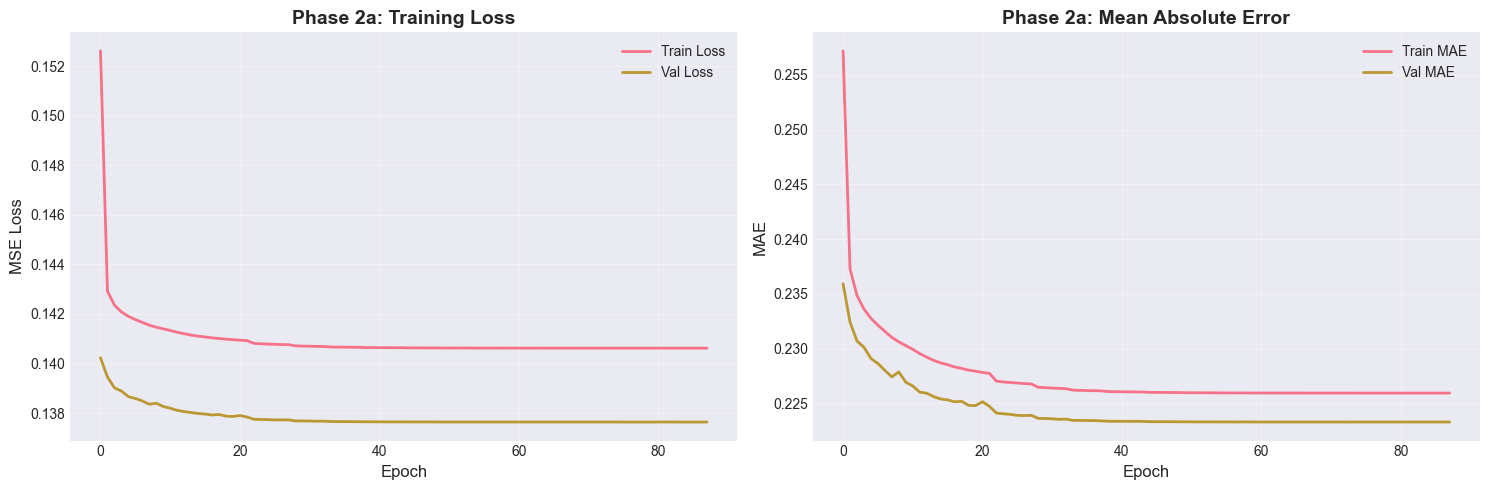

✅ Training curves saved


In [15]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
axes[0].plot(history_2a.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(history_2a.history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('MSE Loss', fontsize=12)
axes[0].set_title('Phase 2a: Training Loss', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# MAE
if 'mae' in history_2a.history:
    axes[1].plot(history_2a.history['mae'], label='Train MAE', linewidth=2)
    axes[1].plot(history_2a.history['val_mae'], label='Val MAE', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('MAE', fontsize=12)
    axes[1].set_title('Phase 2a: Mean Absolute Error', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(phase2a_dir / 'training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Training curves saved")

## Phase 2b: NIH_Normal Autoencoder

**Data:** Only normal NIH images  
**Purpose:** Learn "normal" appearance to detect distribution shift

In [16]:
# Build and train Phase 2b autoencoder (normals only)
# [Similar code to Phase 2a, but using *_normals.h5 files]

print("="*80)
print("PHASE 2b: NIH_NORMAL AUTOENCODER")
print("="*80)

# Load normal images only
train_normal_path = DATA_DIR / 'nih' / 'train_normals.h5'
val_normal_path = DATA_DIR / 'nih' / 'val_normals.h5'

with h5py.File(train_normal_path, 'r') as f:
    X_train_normal = f['images'][:]
    print(f"✅ Training (normals): {X_train_normal.shape}")

with h5py.File(val_normal_path, 'r') as f:
    X_val_normal = f['images'][:]
    print(f"✅ Validation (normals): {X_val_normal.shape}")

# Normalize
if X_train_normal.max() > 1.0:
    X_train_normal = X_train_normal / 255.0
    X_val_normal = X_val_normal / 255.0

# Build new autoencoder
encoder_2b, decoder_2b, autoencoder_2b = build_autoencoder()

# Compile
autoencoder_2b.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

# Setup callbacks
phase2b_dir = RESULTS_DIR / 'phase2b'
phase2b_dir.mkdir(parents=True, exist_ok=True)

callbacks_2b = [
    callbacks.ModelCheckpoint(
        str(phase2b_dir / 'autoencoder_best.keras'),
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

# Train
print("\nStarting training (normals only)...")
history_2b = autoencoder_2b.fit(
    X_train_normal, X_train_normal,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_normal, X_val_normal),
    callbacks=callbacks_2b,
    verbose=1
)

# Save models
autoencoder_2b.save(phase2b_dir / 'autoencoder_final.keras')
encoder_2b.save(phase2b_dir / 'encoder.keras')
decoder_2b.save(phase2b_dir / 'decoder.keras')

print("\n✅ Phase 2b complete!")

PHASE 2b: NIH_NORMAL AUTOENCODER
✅ Training (normals): (42270, 224, 224, 1)
✅ Validation (normals): (9189, 224, 224, 1)

Starting training (normals only)...
Epoch 1/100
1321/1321 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.1804 - mae: 0.3099
Epoch 1: val_loss improved from None to 0.13756, saving model to F:\CAS AML\M3_project\downloads\Results\phase2b\autoencoder_best.keras
1321/1321 ━━━━━━━━━━━━━━━━━━━━ 145s 109ms/step - loss: 0.1554 - mae: 0.2745 - val_loss: 0.1376 - val_mae: 0.2361 - learning_rate: 0.0010
Epoch 2/100
1321/1321 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.1398 - mae: 0.2372
Epoch 2: val_loss improved from 0.13756 to 0.13589, saving model to F:\CAS AML\M3_project\downloads\Results\phase2b\autoencoder_best.keras
1321/1321 ━━━━━━━━━━━━━━━━━━━━ 142s 107ms/step - loss: 0.1394 - mae: 0.2357 - val_loss: 0.1359 - val_mae: 0.2297 - learning_rate: 0.0010
Epoch 3/100
1321/1321 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.1382 - mae: 0.2321
Epoch 3: val_loss improved from 0.13589

---
# 📁 Phase 3: Reconstruction Error Analysis

## Phase 3a: NIH_Full Autoencoder on All Test Images

In [18]:
# Compute reconstruction errors
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""  # hide GPU from PyTorch/Keras
import torch
torch.set_default_device("cpu")

print("="*80)
print("PHASE 3a: RECONSTRUCTION ERROR ANALYSIS")
print("="*80)

# Load best autoencoder
autoencoder_2a_best = keras.models.load_model(phase2a_dir / 'autoencoder_best.keras')

results_3a = {}

for dataset_name in ['nih', 'pediatric', 'chexpert']:
    print(f"\n📊 Processing {dataset_name.upper()}...")
    
    # Load test images
    test_path = DATA_DIR / dataset_name / 'test.h5'
    
    with h5py.File(test_path, 'r') as f:
        X_test = f['images'][:]
    
    if X_test.max() > 1.0:
        X_test = X_test / 255.0
    
    # Reconstruct
    X_reconstructed = autoencoder_2a_best.predict(X_test, batch_size=32, verbose=0)
    
    # Compute per-image MSE
    errors = np.mean((X_test - X_reconstructed) ** 2, axis=(1, 2, 3))
    
    results_3a[dataset_name] = {
        'mean': float(errors.mean()),
        'std': float(errors.std()),
        'median': float(np.median(errors)),
        'min': float(errors.min()),
        'max': float(errors.max()),
        'errors': errors
    }
    
    print(f"   Mean error: {errors.mean():.6f}")
    print(f"   Std:        {errors.std():.6f}")
    print(f"   Range:      [{errors.min():.6f}, {errors.max():.6f}]")

# Save results
phase3a_dir = RESULTS_DIR / 'phase3a'
phase3a_dir.mkdir(parents=True, exist_ok=True)

summary_3a = pd.DataFrame([
    {
        'Dataset': name.upper(),
        'Mean_Error': results_3a[name]['mean'],
        'Std_Error': results_3a[name]['std'],
        'Median_Error': results_3a[name]['median']
    }
    for name in results_3a.keys()
])

summary_3a.to_csv(phase3a_dir / 'phase3a_summary.csv', index=False)

with open(phase3a_dir / 'phase3a_statistics.json', 'w') as f:
    json.dump({k: {kk: vv for kk, vv in v.items() if kk != 'errors'} 
               for k, v in results_3a.items()}, f, indent=2)

print(f"\n✅ Results saved to {phase3a_dir}")

PHASE 3a: RECONSTRUCTION ERROR ANALYSIS

📊 Processing NIH...


MemoryError: Unable to allocate 3.11 GiB for an array with shape (16655, 224, 224, 1) and data type float32

In [ ]:
# Visualize reconstruction errors
fig, ax = plt.subplots(figsize=(10, 6))

dataset_order = ['nih', 'pediatric', 'chexpert']
means = [results_3a[d]['mean'] for d in dataset_order]
labels = [d.upper() for d in dataset_order]

bars = ax.bar(labels, means, color=['#4ECDC4', '#FF6B6B', '#45B7D1'], alpha=0.8, edgecolor='black')

for bar, val in zip(bars, means):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.6f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_ylabel('Mean Reconstruction Error (MSE)', fontsize=14, fontweight='bold')
ax.set_title('Phase 3a: Reconstruction Error by Dataset', fontsize=16, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig(phase3a_dir / 'phase3a_reconstruction_errors.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualization saved")

---
# 📁 Phase 4: Classifier Training & Evaluation

**Model:** DenseNet121-based binary classifier (Normal vs Abnormal)

In [19]:
# Build classifier (DenseNet121 base)
from keras.applications import DenseNet121

def build_classifier(input_shape=(224, 224, 3)):
    """
    Build binary classifier using DenseNet121 backbone
    """
    base_model = DenseNet121(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape,
        pooling='avg'
    )
    
    # Freeze early layers
    for layer in base_model.layers[:100]:
        layer.trainable = False
    
    # Build classifier head
    inputs = layers.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = models.Model(inputs, outputs, name='chest_xray_classifier')
    
    return model

print("Building classifier...")
classifier = build_classifier()
classifier.summary()

Building classifier...
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "chest_xray_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 1024)           │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,300,161 (27.85 MB)

 Trainable params: 6,411,841 (24.46 MB)

 Non-trainable params: 888,320 (3.39 MB)

In [21]:
# Load and prepare NIH data for classifier training
print("="*80)
print("LOADING NIH DATA FOR CLASSIFIER TRAINING")
print("="*80)

# Load train/val/test
with h5py.File(DATA_DIR / 'nih' / 'train.h5', 'r') as f:
    X_train_clf = f['images'][:]
    y_train_clf = f['labels'][:, 0]  # Column 0 = 'No Finding' (1=normal, 0=abnormal)
    # Invert labels: 0=normal, 1=abnormal
    y_train_clf = 1 - y_train_clf

with h5py.File(DATA_DIR / 'nih' / 'val.h5', 'r') as f:
    X_val_clf = f['images'][:]
    y_val_clf = 1 - f['labels'][:, 0]

with h5py.File(DATA_DIR / 'nih' / 'test.h5', 'r') as f:
    X_test_clf = f['images'][:]
    y_test_clf = 1 - f['labels'][:, 0]

# Normalize
if X_train_clf.max() > 1.0:
    X_train_clf = X_train_clf / 255.0
    X_val_clf = X_val_clf / 255.0
    X_test_clf = X_test_clf / 255.0

# Convert grayscale to RGB (DenseNet expects 3 channels)
X_train_clf = np.repeat(X_train_clf, 3, axis=-1)
X_val_clf = np.repeat(X_val_clf, 3, axis=-1)
X_test_clf = np.repeat(X_test_clf, 3, axis=-1)

print(f"✅ Training: {X_train_clf.shape}, Labels: {y_train_clf.shape}")
print(f"✅ Validation: {X_val_clf.shape}, Labels: {y_val_clf.shape}")
print(f"✅ Test: {X_test_clf.shape}, Labels: {y_test_clf.shape}")
print(f"\nClass distribution (train): {np.bincount(y_train_clf.astype(int))}")

LOADING NIH DATA FOR CLASSIFIER TRAINING


MemoryError: Unable to allocate 14.7 GiB for an array with shape (78708, 224, 224, 1) and data type float32

In [ ]:
# Compile and train classifier
print("="*80)
print("TRAINING CLASSIFIER")
print("="*80)

# Compute class weights for imbalanced data
from sklearn.utils.class_weight import compute_class_weight

class_weights_array = compute_class_weight(
    'balanced',
    classes=np.unique(y_train_clf),
    y=y_train_clf
)
class_weights = {i: class_weights_array[i] for i in range(len(class_weights_array))}

print(f"Class weights: {class_weights}")

# Compile
classifier.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.AUC(name='auc')]
)

# Setup callbacks
phase4_dir = RESULTS_DIR / 'phase4'
phase4_dir.mkdir(parents=True, exist_ok=True)

callbacks_4 = [
    callbacks.ModelCheckpoint(
        str(phase4_dir / 'classifier_best.keras'),
        monitor='val_auc',
        mode='max',
        save_best_only=True,
        verbose=1
    ),
    callbacks.EarlyStopping(
        monitor='val_auc',
        mode='max',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

# Train
print("\nStarting training...")
history_4 = classifier.fit(
    X_train_clf, y_train_clf,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_clf, y_val_clf),
    class_weight=class_weights,
    callbacks=callbacks_4,
    verbose=1
)

print("\n✅ Classifier training complete!")

---
# 📁 Phase 5: Correlation Analysis

**Goal:** Test if reconstruction error predicts classifier performance degradation

In [ ]:
# Compute correlations between reconstruction error and classifier performance
print("="*80)
print("PHASE 5: CORRELATION ANALYSIS")
print("="*80)

# Load Phase 3 and Phase 4 results
# Combine reconstruction errors with classifier metrics
# Compute Pearson and Spearman correlations

phase5_dir = RESULTS_DIR / 'phase5'
phase5_dir.mkdir(parents=True, exist_ok=True)

correlation_results = {
    'reconstruction_error': [],
    'balanced_accuracy': [],
    'auc': []
}

# [Add correlation computation code here]

print("\n✅ Correlation analysis complete!")
print(f"Results saved to {phase5_dir}")

---
# 📊 Summary & Conclusions

All phases complete! Check the `Results/` directory for:
- Phase 1: Statistical analysis and JS divergence
- Phase 2: Trained autoencoders
- Phase 3: Reconstruction error analysis
- Phase 4: Classifier evaluation
- Phase 5: Correlation results